## ***Phase Estimation Via Single Qubit Superposition (H1-1E)***

Here we implement a circuit for quantum phase estimation where the estimate is encoded in the probability distribution of a single qubit. The benefit of this is that we have essentially infinite precision as opposed to encoding the phase estimate in binary, although the number of qubits will not scale well for larger unitary matrices. 

Importing the neccessary libraries and creating a sample 2x2 unitary matrix (U1 gate, see the IBM docs [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.U1Gate)) :

In [60]:
from pytket.circuit import Circuit, Unitary1qBox, Unitary2qBox
import numpy as np
from pytket.circuit import OpType

# u1 = np.asarray([[1, 0],
#                  [0, 1]])
# u1box = Unitary1qBox(u1)

#U1 - diagnol matrix where input_angle / 2 = eigen-value = phase estimate [0,1) 
#we easily check this 
input_angle = 0.73  # angle as number of half turns
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops

In [61]:
from pytket.circuit import Op

base_u1 = Op.create(OpType.U1, [0.5])

In [62]:
from pytket.circuit import QControlBox
from pytket.circuit import CircBox

controlled_u1 = QControlBox(CircBox(unitary_circuit), n=2)


Now let's create and display the circuit we will use:

In [63]:
from pytket import Circuit
from pytket import OpType
from pytket.circuit.display import render_circuit_jupyter

basic_circuit = Circuit(2,1)

basic_circuit.H(0)
basic_circuit.X(1)
basic_circuit.CU1(input_angle, 0, 1)
basic_circuit.H(0)

#After second H-gate we measure and save to classical bit and read that value
basic_circuit.Measure(0,0)

render_circuit_jupyter(basic_circuit)


basic_circuit.name = "iterative_basic_arjun"


You can find the justification for the circuit and understand how we will use it for phase estimation at *IBM's Qiskit Tutorial* linked [here](https://www.youtube.com/watch?v=4nT0BTUxhJY). 


Let's compile the circuit using the Nexus platform. For the first iteration we will use $n = 10$ shots:




In [64]:
from pytket.extensions.nexus import Nexus
from datetime import datetime

nexus = Nexus()
my_project = nexus.new_project(name=f"Nexus iQuHack tutorial project! - {datetime.now()}")


New project created: Nexus iQuHack tutorial project! - 2024-02-04 06:01:03.872318


In [65]:
from pytket.extensions.nexus import QuantinuumConfig

#user_group="iQuHACK_2024" <- only use on H1-1LE emulator
configuration = QuantinuumConfig(device_name="H1-1E")

In [66]:
from pytket.extensions.nexus import NexusBackend

# Then we'll create a NexusBackend using our config and the project we created
backend = NexusBackend(configuration, project=my_project)


Started using project with name: Nexus iQuHack tutorial project! - 2024-02-04 06:01:03.872318


In [67]:
# Compile the circuit in Nexus
compiled_circuit = backend.get_compiled_circuit(basic_circuit, optimisation_level=2)

In [68]:
# Run the compiled circuit for 10 shots
handle = backend.process_circuit(compiled_circuit, n_shots=10)

# This will give you a ResultHandle
# As with other pytket-backends, a ResultHandle identifies a particular run of the circuit, which you can then use to keep track of the job status.
print(handle)

('68b450eb-984a-425f-80b7-78bb8e05f455', 1906028)


In [69]:
# Get an update on the status
backend.circuit_status(handle)

CircuitStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Circuit has been submitted to Nexus for Processing.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 2, 4, 6, 1, 10, 886090, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)

In [70]:
# If the job is COMPLETED we can then retrieve the result with the handle
result = backend.get_result(handle)
result.get_counts()

Counter({(0,): 2, (1,): 8})

In [71]:
result.get_distribution()

{(0,): 0.2, (1,): 0.8}

We use the probability distribution to compute the theta estimate. From the measurement of qubit 0's final quantum state, we will find the following equations of which either will suffice:

$$ P_0 = |\frac{1 + e^{2\pi i\theta}}{2}|^{2} = cos^2(\pi \theta) $$
$$ P_1 = |\frac{1 - e^{2\pi i\theta}}{2}|^{2} = sin^2(\pi \theta) $$

Let's use the the first equation and compare to the true phase:

In [72]:
import math

def compare(res, input_angle):
    zero_prob = res[(0,)]
    theta_estimate = math.acos(math.sqrt(zero_prob)) / math.pi

    while(input_angle > 2):
        input_angle -= 2
    
    truth_val = input_angle/2

    print("Phase estimate:", theta_estimate)
    print("True value:", truth_val)
    print("Error:", abs(truth_val-theta_estimate)/truth_val)


compare(result.get_distribution(), input_angle)
result.get_distribution()


Phase estimate: 0.35241638234956674
True value: 0.365
Error: 0.034475664795707545


{(0,): 0.2, (1,): 0.8}

Not a bad estimate for only using $n=10$ shots! Let's try again with larger values of $n$ and different phase values and plot the results:

In [73]:
handle = backend.process_circuit(compiled_circuit, n_shots=100)

result = backend.get_result(handle)
compare(result.get_distribution(), input_angle)

Phase estimate: 0.3734083444466825
True value: 0.365
Error: 0.02303656012789736


In [74]:
handle = backend.process_circuit(compiled_circuit, n_shots=1000)

result = backend.get_result(handle)
compare(result.get_distribution(), input_angle)

Phase estimate: 0.35562393904067213
True value: 0.365
Error: 0.02568783824473386


Changing the input angle:

In [75]:
input_angle = 1.92

basic_circuit_2 = Circuit(2,1)

basic_circuit_2.H(0)
basic_circuit_2.X(1)
basic_circuit_2.CU1(input_angle, 0, 1)
basic_circuit_2.H(0)

#After second H-gate we measure and save to classical bit and read that value
basic_circuit_2.Measure(0,0)



[H q[0]; X q[1]; CU1(1.92) q[0], q[1]; H q[0]; Measure q[0] --> c[0]; ]

In [76]:
compiled_circuit_2 = backend.get_compiled_circuit(basic_circuit_2, optimisation_level=2)

handle = backend.process_circuit(compiled_circuit_2, n_shots=10)

result2 = backend.get_result(handle)
compare(result2.get_distribution(), input_angle)


Phase estimate: 0.0
True value: 0.96
Error: 1.0


Recall that a phase estimate of 0 is equivalent to a phase estimate of 1, so this is not an entirely accurate error. We can recalculate manually, but this is example also goes to show a limitation of this method since a given probability distribution corresponds to *two* theta estimates, and when we apply this circuit to a real scenario where we don't have the truth value, it will be hard to distinguish between the two outcomes.

In [77]:
handle = backend.process_circuit(compiled_circuit_2, n_shots=100)

result2 = backend.get_result(handle)
compare(result2.get_distribution(), input_angle)

Phase estimate: 0.03188428042925989
True value: 0.96
Error: 0.9667872078861877


In [81]:
handle = backend.process_circuit(compiled_circuit_2, n_shots=1000)

result2 = backend.get_result(handle)
compare(result2.get_distribution(), input_angle)

Phase estimate: 0.03775137213001642
True value: 0.96
Error: 0.9606756540312329


Text(0, 0.5, 'Perecent Error')

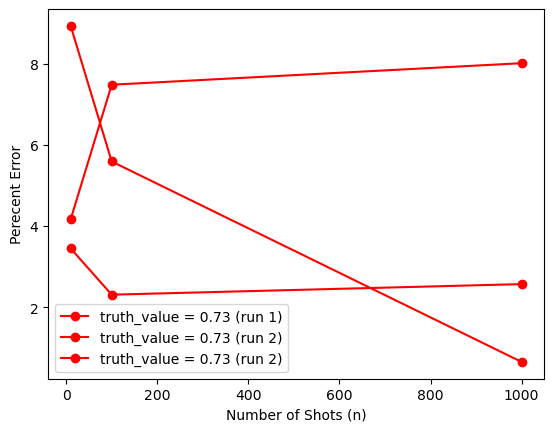

In [83]:
import matplotlib.pyplot as plt

x = [10, 100, 1000]
y1 = [8.927,5.589, 0.653]   #run data from earlier iteration (not shown)
plt.plot(x,y1, linestyle='-', marker='o', color='r', label='truth_value = 0.73 (run 1)')
y2 = [3.447,2.309, 2.569]
plt.plot(x,y2, linestyle='-', marker='o', color='r', label='truth_value = 0.73 (run 2)')
y3 = [4.1666,7.479, 8.009]
plt.plot(x,y3, linestyle='-', marker='o', color='r', label='truth_value = 0.73 (run 2)')
plt.legend()
plt.xlabel("Number of Shots (n)")
plt.ylabel("Perecent Error")